# Prediction Results on Summary Vectronics Data

**Last Modified**: Aug 14, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations on summary sttaistics of Vectronics acceleration data. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass, field
from typing import  List

sys.path.append('.')
sys.path.append('../')

from src.utils.data_prep import (combined_annotations,
                                create_max_windows,
                                create_summary_data,
                                create_data_splits,
                                adjust_behavior_and_durations,
                                setup_dataloaders,)

from src.utils.train import (train_run)
from src.utils.plots import (multi_label_predictions)

from src.methods.prediction_model import (SimpleNN)

from src.utils.io import (get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                          get_matched_data_path,
                          get_matched_metadata_path,
                          get_matched_summary_path,
                          get_matched_annotations_summary_path,
                          get_results_dir
                          )

from config.settings import (SUMMARY_COLLAPSE_BEHAVIORS_MAPPING,
                             SUMMARY_BEHAVIORS,
                             SAMPLING_RATE,
                             id_mapping
                             )
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [26]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['text.usetex'] = False

## 0. Load Matched Data Objects

In [4]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = combined_annotations(video_path=get_video_labels_path(), 
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

all_annotations.Timestamp_start = pd.to_datetime(all_annotations.Timestamp_start)
all_annotations.Timestamp_end = pd.to_datetime(all_annotations.Timestamp_end)
all_annotations['duration'] = (all_annotations.Timestamp_end - all_annotations.Timestamp_start).dt.total_seconds()

In [5]:
values = [10, 20, 30]
quantiles = [np.mean(all_annotations["duration"] <= value) for value in values]
for value, q in zip(values, quantiles):
    print(f"Value {value}s is approximately at the {q:.2f}th percentile.")

Value 10s is approximately at the 0.53th percentile.
Value 20s is approximately at the 0.68th percentile.
Value 30s is approximately at the 0.75th percentile.


In [6]:
#extract behaviors of interest
all_annotations['Behavior'] = all_annotations['Behavior'].replace(SUMMARY_COLLAPSE_BEHAVIORS_MAPPING) # collapse behaviors
all_annotations = all_annotations[all_annotations['Behavior'].isin(SUMMARY_BEHAVIORS)]

# Group and sum durations in hours
duration_table = np.round(all_annotations.groupby(['Source', 'Behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR ANNOTATIONS
Behavior  Feeding  Moving  Running  Stationary
Source                                        
Audio      1.6222  5.2781   3.3297      0.0000
Video      1.4881  3.6972   0.1722     80.8881
Total      3.1103  8.9753   3.5019     80.8881


In [7]:
# load metadata, matched acceleration data, and matched acceleration metadata
metadata = pd.read_csv(get_metadata_path())
acc_data = pd.read_csv(get_matched_data_path())
acc_data_metadata = pd.read_csv(get_matched_metadata_path())

# convert acceleration strings to arrays
acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)

# convert timestamps to datetime objects
acc_data['behavior_start'] = pd.to_datetime(acc_data['behavior_start'])
acc_data['behavior_end'] = pd.to_datetime(acc_data['behavior_end'])

# extract behaviors of interest
acc_data = adjust_behavior_and_durations(acc_data, SUMMARY_COLLAPSE_BEHAVIORS_MAPPING, SUMMARY_BEHAVIORS)
acc_data_metadata = acc_data_metadata.loc[acc_data.index]
acc_data.reset_index()
acc_data_metadata.reset_index()

# Group and sum durations in hours
duration_table = np.round(acc_data.groupby(['Source', 'behavior'])['duration'].sum().div(3600), 4)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print("DURATION SUMMARY FOR MATCHED ANNOTATIONS")
print(duration_df)

DURATION SUMMARY FOR MATCHED ANNOTATIONS
behavior  Feeding  Moving  Running  Stationary
Source                                        
Audio      1.6189  5.2593   3.2337      0.0000
Video      1.3184  1.6700   0.0936     68.0157
Total      2.9373  6.9293   3.3273     68.0157


## 1. Create $X$: Summarize the Vectronics Matched Data

In [8]:
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
feature_cols = [
    'acc_x_ptp_max', 'acc_x_ptp_mean', 'acc_x_mean',
    'acc_y_ptp_max', 'acc_y_ptp_mean','acc_y_mean',
    'acc_z_ptp_max', 'acc_z_ptp_mean', 'acc_z_mean',
]

In [30]:
window_durations = [20.0, 30.0]
datasets = []
# for instances > window duration, split them into multiple instances

for window_duration in window_durations:
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

    # Group and sum durations in hours
    duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

    # Convert to a pivot table: behaviors as rows, sources as columns
    duration_df = duration_table.unstack(fill_value=0)

    # Add a row for total duration per source
    duration_df.loc['Total'] = duration_df.sum()

    print(f"Window duration = {window_duration}")
    print(duration_df)

    datasets.append(create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE))
    

Window duration = 20.0
behavior   Feeding    Moving   Running  Stationary
Source                                            
Audio     1.427778  3.877778  2.377778    0.000000
Video     0.927778  0.466667  0.038889   55.772222
Total     2.355556  4.344444  2.416667   55.772222
Window duration = 30.0
behavior  Feeding    Moving   Running  Stationary
Source                                           
Audio       1.325  3.058333  1.975000    0.000000
Video       0.750  0.225000  0.016667   51.566667
Total       2.075  3.283333  1.991667   51.566667


In [31]:
from scipy.spatial.distance import cdist
from itertools import combinations

def rbf_kernel(X, Y, sigma=1.0):
    """Compute the RBF (Gaussian) kernel between two sets of vectors."""
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-dists / (2 * sigma ** 2))

def compute_mmd(X, Y, sigma=1.0):
    """Biased estimator of MMD², guaranteed to be ≥ 0."""
    K_XX = rbf_kernel(X, X, sigma)
    K_YY = rbf_kernel(Y, Y, sigma)
    K_XY = rbf_kernel(X, Y, sigma)

    mmd2 = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    return mmd2

def mmd_test(X, Y, sigma=1.0, num_permutations=1000, seed=None):
    """Two-sample test using MMD with permutation test to get p-value."""
    rng = np.random.default_rng(seed)
    n, m = len(X), len(Y)
    Z = np.vstack([X, Y])
    observed_mmd = compute_mmd(X, Y, sigma=sigma)

    permuted_mmds = []
    for _ in range(num_permutations):
        idx = rng.permutation(n + m)
        X_perm = Z[idx[:n]]
        Y_perm = Z[idx[n:]]
        permuted_mmds.append(compute_mmd(X_perm, Y_perm, sigma=sigma))

    p_value = np.mean([mmd >= observed_mmd for mmd in permuted_mmds])
    return observed_mmd, permuted_mmds, p_value

def median_pairwise_distance(X, Y):
    Z = np.vstack([X, Y])
    dists = cdist(Z, Z, 'euclidean')
    return np.median(dists[np.triu_indices_from(dists, k=1)])

n, m = 2000, 2000
num_permutations = 100
seed = 42
rng = np.random.default_rng(seed)

datasets = {'window_20': datasets[0][feature_cols].values[rng.permutation(len(datasets[0]))],
            'window_30': datasets[1][feature_cols].values[rng.permutation(len(datasets[1]))]
}

for (name1, Xs), (name2, Xt) in combinations(datasets.items(), 2):
    Xs_sub = Xs[:n, :]
    Xt_sub = Xt[:m, :]
    
    sigma = median_pairwise_distance(Xs_sub, Xt_sub)
    stat, permuted_stat, pval = mmd_test(
        X=Xs_sub,
        Y=Xt_sub,
        sigma=sigma,
        num_permutations=num_permutations,
        seed=seed
    )
    
    print(f"\nComparison: {name1} vs {name2}")
    print(f"MMD² statistic: {stat:.4f}")
    if pval < 0.05:
        print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H₀).")
    else:
        print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H₀).")



Comparison: window_20 vs window_30
MMD² statistic: 0.0004
P-value: 0.3600 - The two distributions are not significantly different (fail to reject H₀).


In [10]:
window_duration = 30.0
# for instances > window duration, split them into multiple instances
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=SAMPLING_RATE)

# extract instances >= window duration
acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

# Group and sum durations in hours
duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print(f"Window duration = {window_duration}")
print(duration_df)

Window duration = 30.0
behavior  Feeding    Moving   Running  Stationary
Source                                           
Audio       1.325  3.058333  1.975000    0.000000
Video       0.750  0.225000  0.016667   51.566667
Total       2.075  3.283333  1.991667   51.566667


In [11]:
# at this point, all instances in `acc_data` are of duration 30 seconds
# create summary data
summary_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)


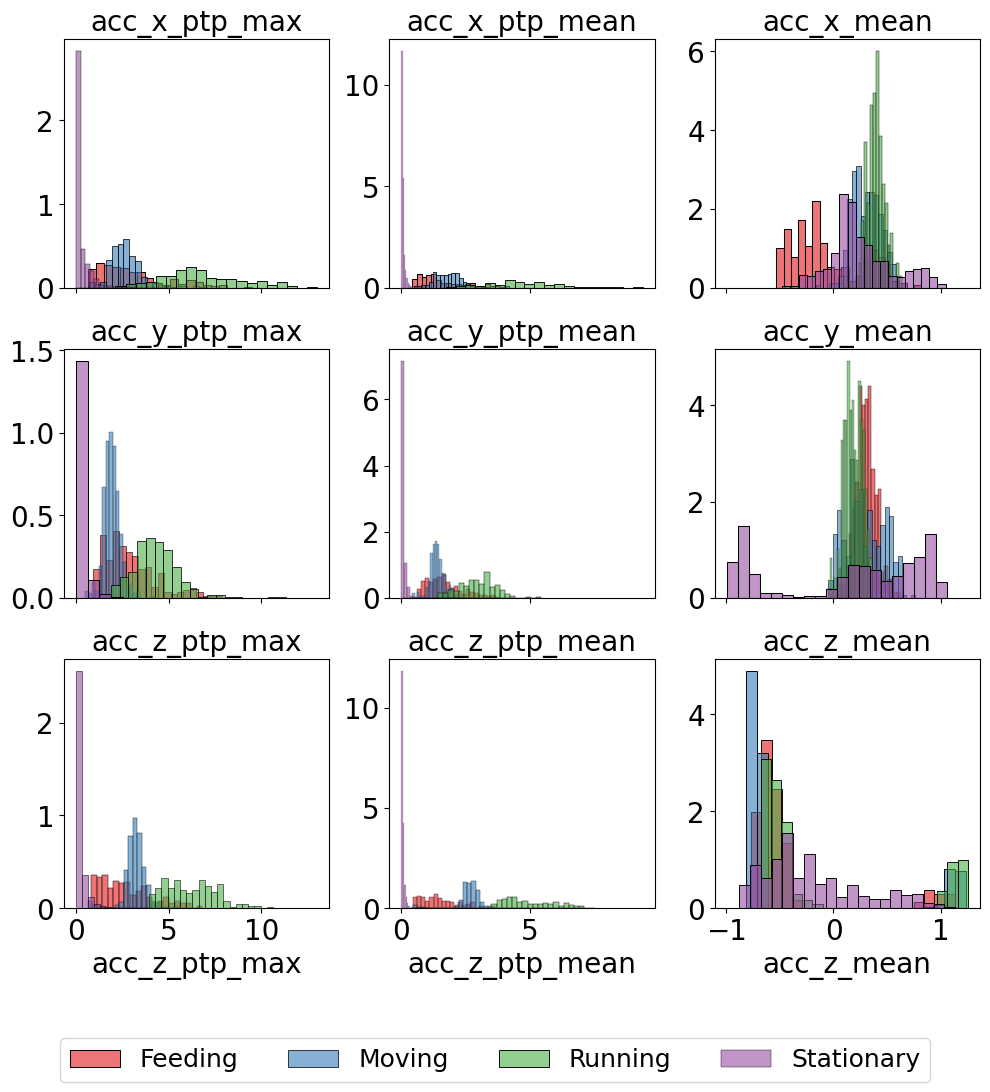

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=False, sharex='col')
palette = sns.color_palette("Set1", n_colors=len(SUMMARY_BEHAVIORS))

behaviors_to_plot = acc_data_split['behavior'].unique()
acc_axes = ['acc_x', 'acc_y', 'acc_z']
features = ['ptp_max', 'ptp_mean', 'mean']

for i, axis in enumerate(acc_axes):
    for j, feature in enumerate(features):

        feature = axis + '_' + feature
        ax = axes[i, j]

        for k, behavior in enumerate(SUMMARY_BEHAVIORS):
            sns.histplot(
                acc_data_split[acc_data_split['behavior'] == behavior][feature],
                label=behavior,
                kde=False,
                ax=ax,
                stat='density',
                bins=20,
                color=palette[k],
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_title(feature)
        ax.set_ylabel("")

# Place legend outside at the bottom center
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(SUMMARY_BEHAVIORS), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

## 2. Predict $Y \mid X$: Train Classification Model

In [13]:
label_encoder = LabelEncoder()
label_encoder.fit(SUMMARY_BEHAVIORS)

training_results_dir = os.path.join(get_results_dir(), 'summary_training_results')
os.makedirs(training_results_dir, exist_ok=True)

In [14]:
# train and model arguments

@dataclass
class TrainArgs:
    batch_size: int = 512
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [64])
    dropout_rate: float = 0.5

train_args = TrainArgs()
model_args = ModelArgs()

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(summary_acc_data, feature_cols=feature_cols)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (4242, 9)
y_train: (4242,)
X_val: (1414, 9)
y_val: (1414,)
X_test: (1414, 9)
y_test: (1414,)


In [16]:
theta_list = np.round(0.1 * np.arange(11), 1)

for theta in tqdm(theta_list, desc="Training models for different theta values"):

    tqdm.write(f"Current theta: {theta}")
    train_args.theta = theta

    # setup dataloaders
    train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

    # setup model, loss, and optimizer
    model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(SUMMARY_BEHAVIORS), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

    #### Training
    train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
    model = train_obj['model'].to(device)
    training_stats = train_obj['training_stats']

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{train_args.theta}")
    os.makedirs(model_dir, exist_ok=True)

    torch.save(model, os.path.join(model_dir, 'model.pt'))
    json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(training_stats, f)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
    np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
    np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
    

Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Current theta: 0.0


Epoch 100/100 | Train Loss: 0.0378 | Val Loss: 0.0277 | Best val Loss: 0.0277: 100%|██████████| 100/100 [00:07<00:00, 14.16it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:08<01:21,  8.12s/it]

Total training time: 0:00:07
Current theta: 0.1


Epoch 100/100 | Train Loss: 0.0507 | Val Loss: 0.0250 | Best val Loss: 0.0250: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]
Training models for different theta values:  18%|█▊        | 2/11 [00:15<01:08,  7.58s/it]

Total training time: 0:00:07
Current theta: 0.2


Epoch 100/100 | Train Loss: 0.0511 | Val Loss: 0.0192 | Best val Loss: 0.0192: 100%|██████████| 100/100 [00:06<00:00, 14.85it/s]
Training models for different theta values:  27%|██▋       | 3/11 [00:22<00:57,  7.20s/it]

Total training time: 0:00:07
Current theta: 0.3


Epoch 100/100 | Train Loss: 0.0564 | Val Loss: 0.0184 | Best val Loss: 0.0184: 100%|██████████| 100/100 [00:06<00:00, 15.35it/s]
Training models for different theta values:  36%|███▋      | 4/11 [00:28<00:48,  6.94s/it]

Total training time: 0:00:07
Current theta: 0.4


Epoch 100/100 | Train Loss: 0.0608 | Val Loss: 0.0175 | Best val Loss: 0.0175: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]
Training models for different theta values:  45%|████▌     | 5/11 [00:36<00:42,  7.14s/it]

Total training time: 0:00:07
Current theta: 0.5


Epoch 100/100 | Train Loss: 0.0714 | Val Loss: 0.0166 | Best val Loss: 0.0166: 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [00:42<00:34,  6.92s/it]

Total training time: 0:00:06
Current theta: 0.6


Epoch 100/100 | Train Loss: 0.0656 | Val Loss: 0.0153 | Best val Loss: 0.0153: 100%|██████████| 100/100 [00:06<00:00, 14.33it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [00:49<00:27,  6.95s/it]

Total training time: 0:00:07
Current theta: 0.7


Epoch 100/100 | Train Loss: 0.0694 | Val Loss: 0.0134 | Best val Loss: 0.0134: 100%|██████████| 100/100 [00:06<00:00, 14.98it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [00:56<00:20,  6.87s/it]

Total training time: 0:00:07
Current theta: 0.8


Epoch 100/100 | Train Loss: 0.0741 | Val Loss: 0.0182 | Best val Loss: 0.0182: 100%|██████████| 100/100 [00:06<00:00, 14.41it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [01:03<00:13,  6.90s/it]

Total training time: 0:00:07
Current theta: 0.9


Epoch 100/100 | Train Loss: 0.0728 | Val Loss: 0.0131 | Best val Loss: 0.0131: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]
Training models for different theta values:  91%|█████████ | 10/11 [01:09<00:06,  6.64s/it]

Total training time: 0:00:06
Current theta: 1.0


Epoch 100/100 | Train Loss: 0.0773 | Val Loss: 0.0191 | Best val Loss: 0.0190: 100%|██████████| 100/100 [00:06<00:00, 14.73it/s]
Training models for different theta values: 100%|██████████| 11/11 [01:16<00:00,  6.92s/it]

Total training time: 0:00:07


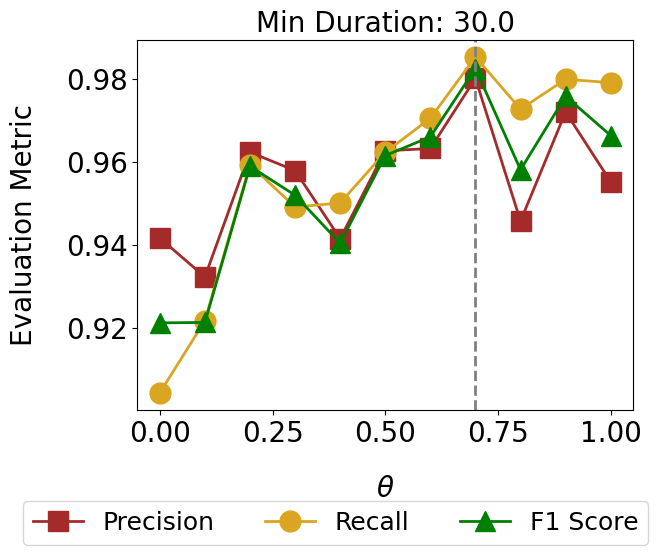

In [17]:
colors = ['brown', 'goldenrod', 'green']

precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

for j, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")

    precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(x=0.7, linestyle='--', color='grey', linewidth=2,)
plt.title(f"Min Duration: {window_duration}")
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.4))
# plt.tight_layout()
plt.show()  

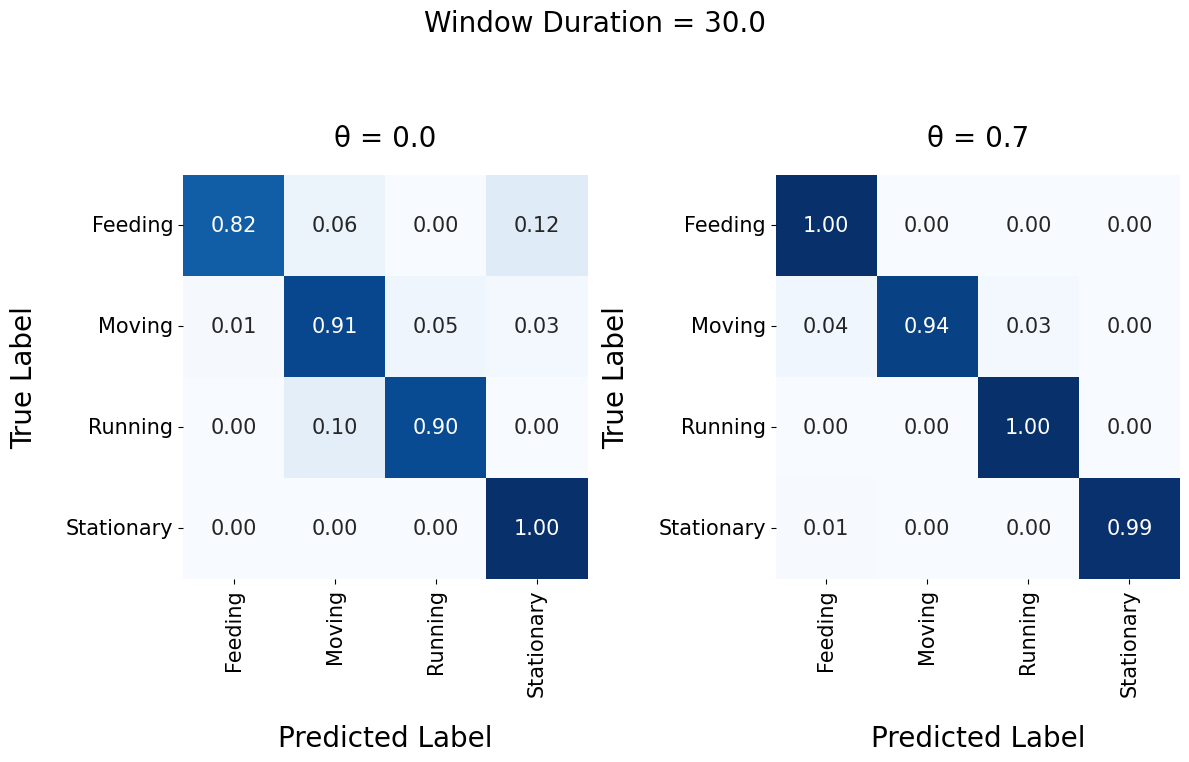

In [ ]:
theta_list = [0.0, 0.7]
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"θ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {window_duration}", fontsize=20)
plt.tight_layout()
plt.show()

## 3. Test the Model on Summaries on 20 seconds

In [ ]:
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=20.0, sampling_rate=SAMPLING_RATE)
summary_acc_data_20 = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

X = summary_acc_data_20[feature_cols].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(summary_acc_data_20['behavior'])

(18560, 9) (18560,)


In [33]:
window_duration_star, theta_star = 30.0, 0.7
model_dir = os.path.join(training_results_dir, f"duration{window_duration_star}_theta{theta_star}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [40]:
with torch.no_grad():
    y_pred = torch.argmax(model(torch.tensor(X, dtype=torch.float32).to(device)), dim=1)

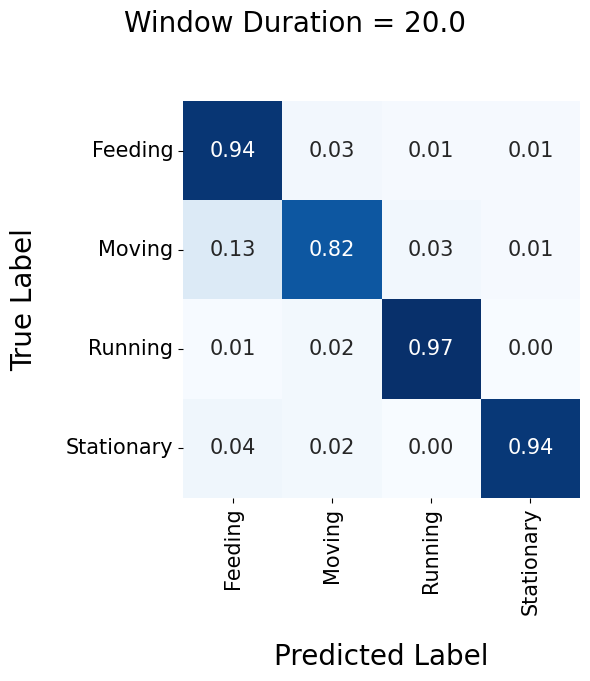

In [47]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 7))

cm = confusion_matrix(y, y_pred.detach().cpu().numpy(), normalize='true')
class_names = label_encoder.inverse_transform(np.arange(len(np.unique(y))))

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)

ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
fig.suptitle(f"Window Duration = 20.0", fontsize=20)
plt.tight_layout()
plt.show()